## Data Exploration

In [1]:

s3_data ="s3://aegovan-data/human_output/human_keyinteractions.json"
s3_annotations ="s3://aegovan-data/input_data_pubtator_annotated.txt"
human_idmapping_dat = "/Users/aeg/Downloads/HUMAN_9606_idmapping.dat"

In [2]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


In [3]:
data_file="input_data.json"
annotations_file="input_data_annotations.txt"

In [4]:
download_single_file(s3_data, data_file)

In [5]:
download_single_file(s3_annotations, annotations_file)

In [9]:

import pandas as pd

data = pd.read_json(data_file)

print("Total number of records: {}".format(data.shape[0]))

Total number of records: 3381


In [10]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

## Preliminary data transformations

In [12]:
#TODO: Fix data format
data["pubmedId"] = data["pubmedId"].astype(str)
data["interactionId"] = data["interactionId"].astype(str)
data["isValid"] =  data.isNegative.isin(['false', '0', 'False'])
data = data.drop('isNegative', axis=1)

### Sneak preview of the data

In [13]:
data.head(n=3)

,interactionId,interactionType,participants,pubmedId,pubmedTitle,pubmedabstract,isValid
0,2503510,phosphorylation,"[{'uniprotid': 'P43405', 'alias': [['ksyk_human'], ['Tyrosine-protein kinase SYK'], ['SYK'], ['Spleen tyrosine kinase'], ['p72-Syk']]}]",25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases.",True
1,2503513,phosphorylation,"[{'uniprotid': 'P43405', 'alias': [['ksyk_human'], ['Tyrosine-protein kinase SYK'], ['SYK'], ['Spleen tyrosine kinase'], ['p72-Syk']]}, {'uniprotid': 'Q9BSZ5', 'alias': [['asc_human'], ['Apoptosis-associated speck-like protein containing a CARD'], ['PYD and CARD domain-containing protein'], ['Target of methylation-induced silencing 1'], ['Caspase recruitment domain-containing protein 5'], ['ASC'], ['CARD5'], ['TMS1'], ['PYCARD']]}]",25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases.",True
10,1796163,phosphorylation,"[{'uniprotid': 'Q8WUB1', 'alias': [['kc1g2_human'], ['Casein kinase I isoform gamma-2'], ['CK1G2'], ['CSNK1G2']]}, {'uniprotid': 'Q6ZS50', 'alias': [['lrrk2_human'], ['Leucine-rich repeat serine/threonine-protein kinase 2'], ['LRRK2'], ['PARK8'], ['Dardarin']]}]",25500533,None,"LRRK2, a gene relevant to Parkinson's disease, encodes a 

In [14]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

### Number of interactions per paper
**Note: The number of interactions per paper only takes the filtered interactions extracted from the Intact database**

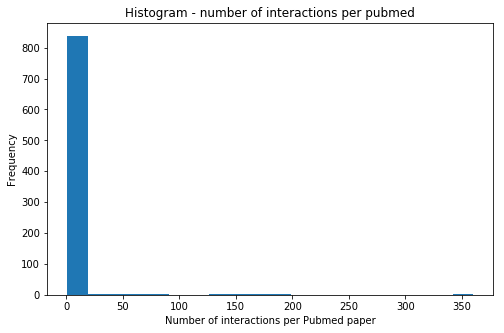

In [20]:
import matplotlib.pyplot as plt
import numpy as np 



#sns.distplot(data.pubmedId.value_counts().tolist(), bins=100, kde=False, norm_hist=True)

data.pubmedId.value_counts().plot.hist (bins=20,figsize=(8,5), density=False, rwidth=1)
plt.title('Histogram - number of interactions per pubmed')
plt.xlabel('Number of interactions per Pubmed paper')
plt.ylabel('Frequency')

#plt.show()
plt.savefig('PaperVsInteractions.svg', bbox_inches='tight')
plt.savefig('PaperVsInteractions.jpg', bbox_inches='tight')
plt.show()

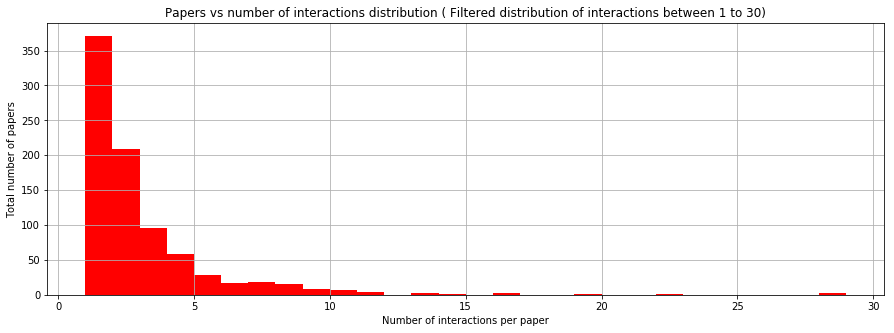

In [21]:
df = data.pubmedId.value_counts().hist (bins=range(1, 30), figsize=(15,5), color = 'red')

plt.title('Papers vs number of interactions distribution ( Filtered distribution of interactions between 1 to 30)')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

### Filter out interactions from paper with more than 15 interactions

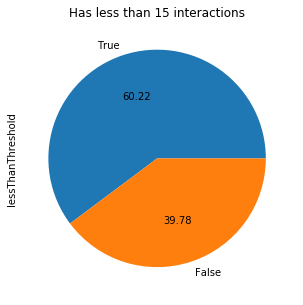

In [22]:
pubmed_interaction_count = data.pubmedId.value_counts().to_frame().rename(columns={"pubmedId":"interactionCountPerPubmed"})


interactions_count= pd.DataFrame()
data["lessThanThreshold"] = data.apply(lambda r: r["pubmedId"] in  pubmed_interaction_count.query('interactionCountPerPubmed <= 15').index , 1)


data.lessThanThreshold.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has less than 15 interactions')
plt.show()

In [23]:
data = data.query("lessThanThreshold == 1")

In [24]:
print("Total number of records after filter: {}".format(data.shape[0]))

Total number of records after filter: 2036


### Interaction Types distribution

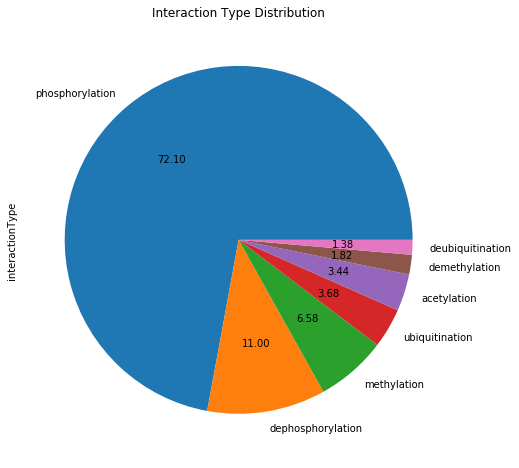

In [25]:
data.interactionType.value_counts().plot.pie(autopct='%.2f',figsize=(8, 8))
plt.title('Interaction Type Distribution')
plt.savefig("Interactiontype.svg")
plt.show()

In [26]:
data.interactionType.value_counts().to_frame()

,interactionType
phosphorylation,1468
dephosphorylation,224
methylation,134
ubiquitination,75
acetylation,70
demethylation,37
deubiquitination,28


### Distinct interaction types per paper

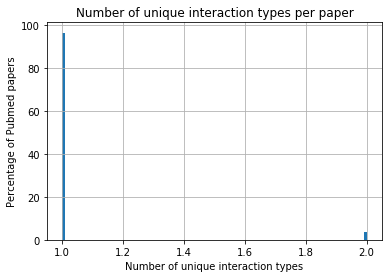

In [27]:
import numpy as np

distinct_no_papers = data['pubmedId'].nunique()

data.groupby('pubmedId')['interactionType'].nunique().hist(bins=100, density=1)
plt.title("Number of unique interaction types per paper")
plt.xlabel('Number of unique interaction types')
plt.ylabel('Percentage of Pubmed papers'.format(distinct_no_papers))
plt.show()


### Postive vs Negative Relationships

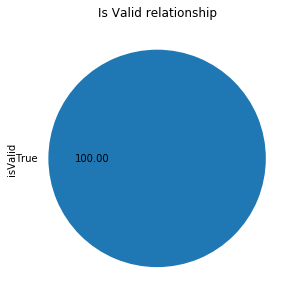

In [28]:
data.isValid.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Is Valid relationship')
plt.show()

### Number of participants per interaction

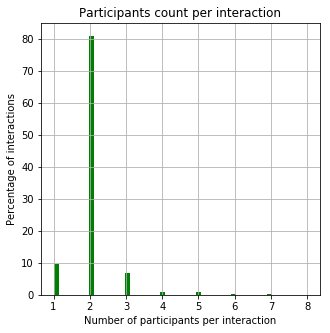

In [29]:
import numpy as np
temp_part = data["participants"].apply(lambda x: len(x))

temp_part.hist (bins=50, figsize=(5,5), color = 'green',  weights = np.ones_like(temp_part.index)*100 / len(temp_part.index))
plt.title("Participants count per interaction")
plt.xlabel('Number of participants per interaction')
plt.ylabel('Percentage of interactions')
plt.savefig("ParticipantsPerInteraction.svg")
plt.show()

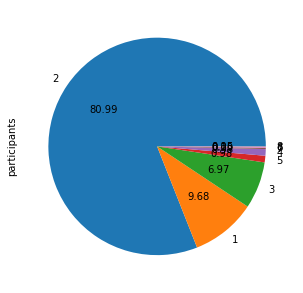

In [30]:
temp_part.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))

### Explore if the abstract contains the trigger word

In [31]:
data["hasTriggerWord"] = data.apply(lambda r: r["interactionType"].lower() in r["pubmedabstract"].lower() , 1)

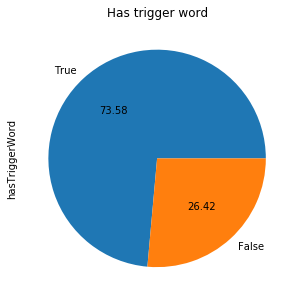

In [32]:
data.hasTriggerWord.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has trigger word')
plt.show()

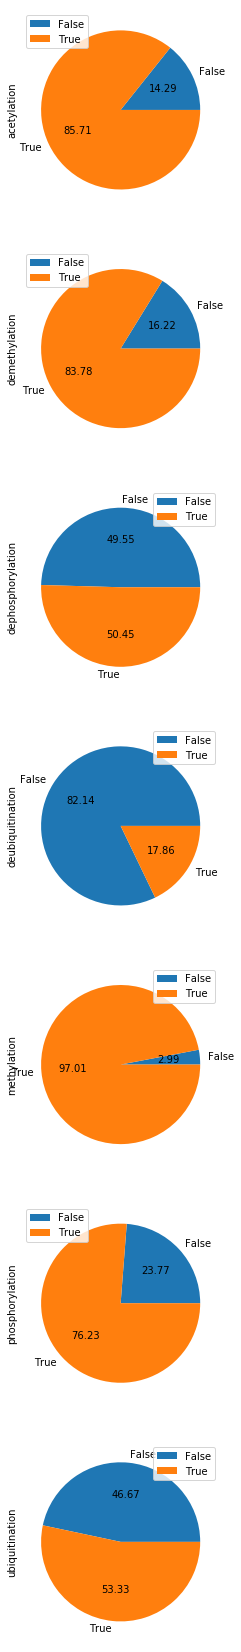

In [33]:
fig, ax = plt.subplots( 7,1, figsize=(45,30))
data.groupby(['hasTriggerWord', 'interactionType']).size().unstack().plot(kind='pie', subplots='True',autopct='%.2f', ax=ax)
plt.show()

### Explore how many of the entity alias are mentioned in the abstract

In [34]:
%%time 

from difflib import SequenceMatcher
def getEntityMentionsCount(r):
    count = 0
    abstract = r["pubmedabstract"].lower()
    abstract_len= len(abstract)
    for p in r["participants"]:
        if p is None or p['alias'] is None : continue
        
        for a in p['alias']:
            alias = a[0].lower()
            s = SequenceMatcher(None, abstract, alias)
            _,_,match_size = s.find_longest_match(0, len(abstract), 0, len(alias))
            if match_size >= 3 and match_size >= len(alias)/2 :
                count += 1
        
    return count
        

data["entityMentionsCount"] = data.apply(lambda r: getEntityMentionsCount(r)  , 1)

CPU times: user 16 s, sys: 124 ms, total: 16.1 s
Wall time: 16.3 s


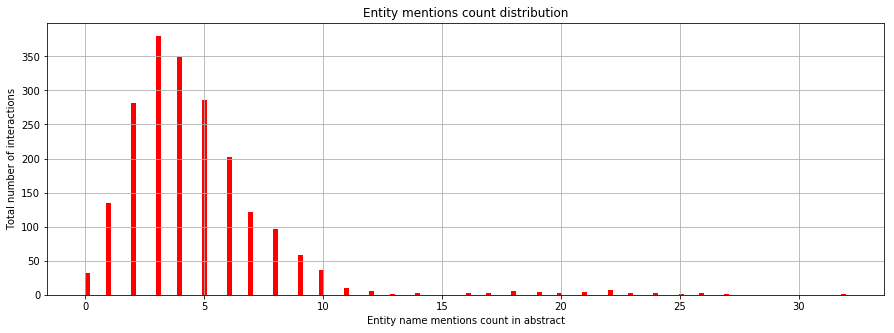

In [35]:
data['entityMentionsCount'].hist ( bins=150, figsize=(15,5), color = 'red')
plt.title('Entity mentions count distribution')
plt.xlabel('Entity name mentions count in abstract')
plt.ylabel('Total number of interactions')

plt.show()

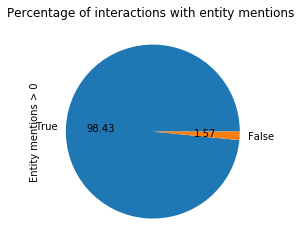

In [36]:
(data['entityMentionsCount'] > 0).value_counts().plot.pie(autopct='%.2f')
plt.title("Percentage of interactions with entity mentions ")
plt.ylabel("Entity mentions > 0")
plt.show()

### Randomly eye ball interactions with no entity mentions

In [ ]:

data.query('entityMentionsCount == 0')[['participants','pubmedabstract' ]].sample(n=10)


In [ ]:
data.head(n=10)

### Data Transformation

In [37]:
from datatransformer.jsonPPIFlattenTransformer import IntactJsonPpiFlattenTransformer
 

sut = IntactJsonPpiFlattenTransformer()

data_transformed = sut.transform(data)


In [38]:
data_transformed.head(n=2)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,pubmedId,pubmedTitle,pubmedabstract
0,1,True,2503510,phosphorylation,True,True,"[[ksyk_human], [Tyrosine-protein kinase SYK], [SYK], [Spleen tyrosine kinase], [p72-Syk]]",P43405,"[[ksyk_human], [Tyrosine-protein kinase SYK], [SYK], [Spleen tyrosine kinase], [p72-Syk]]",P43405,25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases."
1,2,True,2503513,phosphorylation,True,True,"[[ksyk_human], [Tyrosine-protein kinase SYK], [SYK], [Spleen tyrosine kinase], [p72-Syk]]",P43405,"[[asc_human], [Apoptosis-associated speck-like protein containing a CARD], [PYD and CARD domain-containing protein], [Target of methylation-induced silencing 1], [Caspase recruitment domain-containing protein 5], [ASC], [CARD5], [TMS1], [PYCARD]]",Q9BSZ5,25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases."


In [39]:
data_transformed.shape

(2749, 13)

Okay.. looks like it is only a case of the names of the participants not matching the names of the alias used in the abstract.. 

### Data Engineering

#### Add more negative samples

In [40]:

def generate_negative_old(data):
    import uuid
    unique_pubmeds = data["pubmedId"].unique()
    data_fake = pd.DataFrame(columns=data.columns)

    num_fake_records = int( .50 * len(data))
    #TODO: Randomise this, biased via
    for u in unique_pubmeds:
        fake_records = pd.DataFrame(data[ data.pubmedId != u]  ).sample(n=1) 
        fake_records.loc[:, "interactionId"] =  fake_records.interactionId.astype(str) + "_" + str(uuid.uuid4() ) + "_" + "fake"
        fake_records.loc[:,"isValid"] = 'False' 
        ## Copy of the pubmeid abtract and the title from a id
        fake_records.loc[:,"pubmedId"] = u
        fake_records.loc[:, "pubmedTitle"] =  data[ data.pubmedId == u].iloc[0]["pubmedTitle"]
        fake_records.loc[:, "pubmedabstract"] =  data[ data.pubmedId == u].iloc[0]["pubmedabstract"]


        data_fake = data_fake.append(fake_records, ignore_index=True)
        if len(data_fake) > num_fake_records:
            break
            
    return data_fake
  
    

In [41]:

def generate_negative(data, enity_annotations_file):
    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.gnormplusNegativeSamplesAugmentor import GnormplusNegativeSamplesAugmentor
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper
    from datatransformer.interactionTypeNegativeSamplesAugmentor import InteractionTypeNegativeSamplesAugmentor

    import os
    
 
    localdb = human_idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
            
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))

        negative_samples_generator = GnormplusNegativeSamplesAugmentor(annotations_json, mapper)
        result = negative_samples_generator.transform(data)
        
        negative_samples_generator = InteractionTypeNegativeSamplesAugmentor()
        result = negative_samples_generator.transform(result)

        return result

Remove records where the alias is null

In [42]:
data_filtered = data_transformed[data_transformed.participant1Alias.notnull()]
data_filtered = data_filtered[data_filtered.participant2Alias.notnull()]

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
trainpubmed, testpubmed = train_test_split(data_filtered.pubmedId.unique(), test_size=.2,
                                                        random_state=777)

trainpubmed, valpubmed = train_test_split(trainpubmed, test_size=.2,
                                                        random_state=777)

In [44]:
train = data_filtered[data_filtered['pubmedId'].isin(trainpubmed)]
test = data_filtered[data_filtered['pubmedId'].isin(testpubmed)]
val = data_filtered[data_filtered['pubmedId'].isin(valpubmed)]




In [45]:
train = generate_negative(train, annotations_file)
print("The total number of train records including fake records {}".format(train.shape[0]))


UndefinedVariableError: name 'isNegative' is not defined

In [ ]:


test = generate_negative(test,  annotations_file)
print("The total number of test records including fake records {}".format(test.shape[0]))


val = generate_negative(val, annotations_file)
print("The total number of val records including fake records {}".format(val.shape[0]))

In [ ]:
train.sort_values(by=["pubmedId"]).query("interactionType != 'phosphorylation'").head(n=10)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots( 1,2, figsize=(8,3))

#fig, ax = plt.subplots( 7,1, figsize=(45,30))
train.groupby(['interactionType', 'isNegative']).size().unstack().plot.bar(ax=ax[0])
ax[0].set_title( "Training set")


val.groupby(['interactionType', 'isNegative']).size().unstack().plot.bar(ax=ax[1])
ax[1].set_title( "Validation set")


plt.savefig("NegativeSample.svg",bbox_inches = "tight")
plt.show()

In [ ]:
fig, ax = plt.subplots( 6,1, figsize=(10,20))

val.groupby(['isNegative', 'interactionType']).size().unstack().plot(kind='pie', subplots='True',autopct='%.2f', ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots( 7,1, figsize=(10,20))

train.groupby(['isNegative', 'interactionType']).size().unstack().plot(kind='pie', subplots='True',autopct='%.2f', ax=ax)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
val.isNegative.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.savefig("Interaction.png")

In [ ]:
train.to_json("train.json")
test.to_json("test.json")
val.to_json("val.json")

### Train val split such that the pubmedid do not overladp

In [ ]:
from sklearn.model_selection import train_test_split
trainpubmed, testpubmed = train_test_split(data_filtered.pubmedId.unique(), test_size=.2,
                                                        random_state=777)

trainpubmed, valpubmed = train_test_split(trainpubmed, test_size=.2,
                                                        random_state=777)

In [ ]:
print("Unique pubmeds in train {}, test {} and val {}".format(len(trainpubmed), len(testpubmed),len(valpubmed)))

In [ ]:
train = data_filtered[data_filtered['pubmedId'].isin(trainpubmed)]
test = data_filtered[data_filtered['pubmedId'].isin(testpubmed)]
val = data_filtered[data_filtered['pubmedId'].isin(valpubmed)]



In [ ]:

train = generate_negative(train,  annotations_file)
print("The total number of train records including fake records {}".format(train.shape[0]))



test = generate_negative(test,  annotations_file)
print("The total number of test records including fake records {}".format(test.shape[0]))


val = generate_negative(val, annotations_file)
print("The total number of val records including fake records {}".format(val.shape[0]))

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots( 3,1, figsize=(50,30))
train.isNegative.value_counts().plot.pie(autopct='%.2f',ax=ax[1])


val.isNegative.value_counts().plot.pie(autopct='%.2f',ax=ax[0])

test.isNegative.value_counts().plot.pie(autopct='%.2f',ax=ax[2])

In [ ]:
train.to_json("train_unique_pub.json")
test.to_json("test_unique_pub.json")
val.to_json("val_unique_pub.json")

In [ ]:
train.head(n=3)